In [1]:
from __future__ import print_function
import keras
# import keras_tuner
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from keras import backend as K
# from keras.engine import training
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from functools import partial
import tensorflow.experimental.numpy as tnp

## Loading data

First, we load in the data and split it into a train and test set. 

In [2]:
# load the grayscale images and two-integer labels
images = np.load('images.npy')
labels = np.load('labels.npy')
images = images.astype('float32')
images /= 255

# input image dimensions
img_rows, img_cols = 150, 150

# reshape the 2D input data to 4D to fit the conv2D layer
if K.image_data_format() == 'channels_first':
    images = images.reshape(images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    images = images.reshape(images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# the data, split between train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (14400, 150, 150, 1)
14400 train samples
3600 test samples


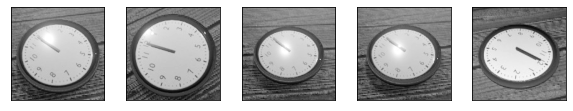

In [3]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i],cmap='gray')
plt.show()

## Regression

In [4]:
# basic parameter settings
batch_size = 32 # 32>64>128
epochs = 160

# change the two-interger labels to a float
y_reg_train = y_train[:, 0] + y_train[:, 1] / 60.0
y_reg_test = y_test[:, 0] + y_test[:, 1] / 60.0

# define the custom mean absolute error function
def custom_mae(y_true, y_pred):
    differences = K.abs(y_true - y_pred)
    diff = K.mean(differences, axis=-1)
    return diff

# the common sense error for regression model
def common_sense_reg(y_true, y_pred):
    differences = K.abs(y_true - y_pred)
    diff = K.minimum(differences, tf.subtract(12.0, differences))
    return diff

In [6]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")
reg_model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=input_shape), # worse: kernel_size=3, filters=32
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2), 
  DefaultConv2D(filters=256), # add a 256-filter block here
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.15), # better having this
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.15),
  keras.layers.Dense(1, activation='linear'),
])

In [7]:
print(reg_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 150, 150, 64)      3200      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 256)      

In [8]:
# reg_model.compile(loss="mean_absolute_error", optimizer='sgd', metrics=[tf.keras.losses.MeanAbsoluteError()])
reg_model.compile(loss=custom_mae, optimizer='sgd', metrics=[common_sense_reg])

reg_history = reg_model.fit(X_train, y_reg_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_reg_test))
score = reg_model.evaluate(X_test, y_reg_test, verbose=0)
print('Test mean absolute error:', score[0])
print('Test common sense error:', score[1])

Epoch 1/160


2022-11-25 06:40:23.904952: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


450/450 [==============================] - 24s 38ms/step - loss: 3.2492 - common_sense_reg: 2.9970 - val_loss: 2.9786 - val_common_sense_reg: 2.9689
Epoch 2/160
450/450 [==============================] - 16s 35ms/step - loss: 3.0748 - common_sense_reg: 3.0096 - val_loss: 2.9776 - val_common_sense_reg: 2.9692
Epoch 3/160
450/450 [==============================] - 15s 33ms/step - loss: 3.0655 - common_sense_reg: 2.9999 - val_loss: 2.9982 - val_common_sense_reg: 2.9758
Epoch 4/160
450/450 [==============================] - 15s 33ms/step - loss: 3.0578 - common_sense_reg: 3.0036 - val_loss: 3.0096 - val_common_sense_reg: 2.9779
Epoch 5/160
450/450 [==============================] - 15s 34ms/step - loss: 3.0533 - common_sense_reg: 3.0024 - val_loss: 2.9739 - val_common_sense_reg: 2.9703
Epoch 6/160
450/450 [==============================] - 15s 34ms/step - loss: 3.0473 - common_sense_reg: 2.9994 - val_loss: 3.0608 - val_common_sense_reg: 2.9647
Epoch 7/160
450/450 [=========================

In [9]:
reg_model.save("regression.h5")

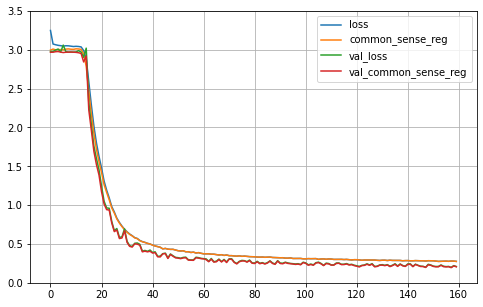

In [10]:
pd.DataFrame(reg_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3.5)
plt.show()

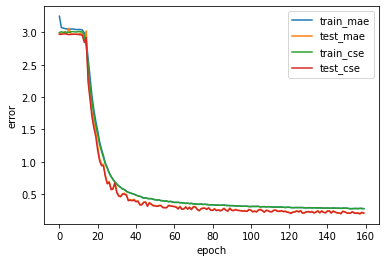

In [13]:
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.plot(reg_history.history['common_sense_reg'])
plt.plot(reg_history.history['val_common_sense_reg'])
# plt.title('Regression')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train_mae', 'test_mae', 'train_cse', 'test_cse'], loc='upper right')
plt.show()

## Classification

In [26]:
# basic parameter settings
batch_size = 64 # tuning this？
num_classes = 720 # 24 or 720
epochs = 60 # 24: 200， 720: 60

# change the two-integer labels to 24 or 720 classes
def classification_label(y, num_classes):
    label = []
    if num_classes == 24:
        for i in y:
            if i[1] <= 30:
                label.append(2 * i[0])
            else:
                label.append(2 * i[0] + 1)
    else: # num_classes == 720
        for i in y:
            label.append(60 * i[0] + i[1])
    return label

y_class_train = np.array(classification_label(y_train, num_classes))
y_class_test = np.array(classification_label(y_test, num_classes))

# convert class vectors to binary class matrices
y_class_train = keras.utils.to_categorical(y_class_train, num_classes)
y_class_test = keras.utils.to_categorical(y_class_test, num_classes)

# the common sense accuracy for classification model
def common_sense_class(y_true, y_pred):
    differences = K.abs(tf.math.argmax(y_true, 1) - tf.math.argmax(y_pred, 1))
    # num_classes = tf.cast(num_classes, tf.int64)
    differences = tf.cast(differences, tf.int32)
    diff = tf.math.minimum(differences, tf.subtract(num_classes, differences))
    return diff

In [18]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="same")
class_model_1 = keras.models.Sequential([
  DefaultConv2D(filters=32, input_shape=input_shape), # worse: kernel_size=3, filters=32
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.2),
    
  DefaultConv2D(filters=64),
  DefaultConv2D(filters=64),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.2),
    
  # DefaultConv2D(filters=96),
  DefaultConv2D(filters=96),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.2),

  # DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.2),

  keras.layers.Flatten(),
  keras.layers.Dense(units=256, activation='relu'),
  keras.layers.Dropout(0.2), # better having this
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(units=num_classes, activation='softmax')
])

In [19]:
class_model_1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adadelta(learning_rate=0.1), metrics=["accuracy", common_sense_class])
# class_model_1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adadelta(learning_rate=0.1), metrics=["accuracy"])

class_history_1 = class_model_1.fit(X_train, y_class_train,
        batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_class_test))
class_score_1 = class_model_1.evaluate(X_test, y_class_test, verbose=0)
print('Test loss:', class_score_1[0])
print('Test accuracy:', class_score_1[1])
print('Test common sense error:', class_score_1[2])

Epoch 1/200
225/225 [==============================] - 8s 32ms/step - loss: 3.2613 - accuracy: 0.0444 - common_sense_class: 5.8911 - val_loss: 3.2477 - val_accuracy: 0.0453 - val_common_sense_class: 5.9372
Epoch 2/200
225/225 [==============================] - 6s 27ms/step - loss: 3.1709 - accuracy: 0.0501 - common_sense_class: 5.6805 - val_loss: 3.2418 - val_accuracy: 0.0453 - val_common_sense_class: 5.9372
Epoch 3/200
225/225 [==============================] - 6s 28ms/step - loss: 3.0730 - accuracy: 0.0720 - common_sense_class: 5.1961 - val_loss: 3.3718 - val_accuracy: 0.0431 - val_common_sense_class: 5.9817
Epoch 4/200
225/225 [==============================] - 6s 28ms/step - loss: 2.9029 - accuracy: 0.1054 - common_sense_class: 4.6284 - val_loss: 3.0072 - val_accuracy: 0.0811 - val_common_sense_class: 4.9150
Epoch 5/200
225/225 [==============================] - 6s 28ms/step - loss: 2.7115 - accuracy: 0.1404 - common_sense_class: 4.1619 - val_loss: 2.8391 - val_accuracy: 0.1158 - v

In [20]:
class_model_1.save("Classification_24.h5")

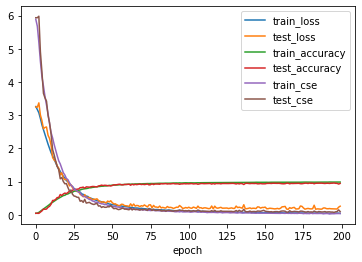

In [25]:
plt.plot(class_history_1.history['loss'])
plt.plot(class_history_1.history['val_loss'])
plt.plot(class_history_1.history['accuracy'])
plt.plot(class_history_1.history['val_accuracy'])
plt.plot(class_history_1.history['common_sense_class'])
plt.plot(class_history_1.history['val_common_sense_class'])
# plt.title('Classification_24')
# plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss', 'train_accuracy', 'test_accuracy', 'train_cse', 'test_cse'], loc='upper right')
plt.show()

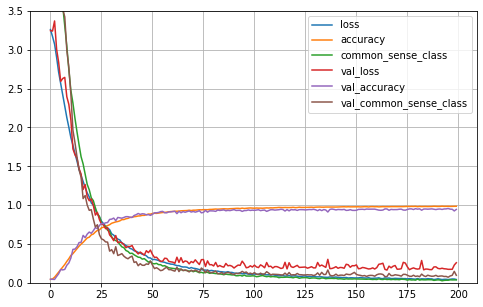

In [22]:
pd.DataFrame(class_history_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3.5)
plt.show()

In [27]:
class_model_2 = keras.models.Sequential([
  DefaultConv2D(filters=32, input_shape=input_shape), # worse: kernel_size=3, filters=32
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.2),
    
  DefaultConv2D(filters=64),
  DefaultConv2D(filters=64),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.2),
    
  DefaultConv2D(filters=96), #
  DefaultConv2D(filters=96),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.2),

  DefaultConv2D(filters=128), #
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.2),

  keras.layers.Flatten(),
  keras.layers.Dense(units=256, activation='relu'), #
  keras.layers.Dropout(0.2), # better having this
  keras.layers.Dense(units=128, activation='relu'), #
  keras.layers.Dropout(0.2),
  keras.layers.Dense(units=num_classes, activation='softmax')
])

In [28]:
class_model_2.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adadelta(learning_rate=0.08), metrics=["accuracy", common_sense_class])
# class_model_2.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=[common_sense_class])

class_history_2 = class_model_2.fit(X_train, y_class_train,
        batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_class_test))
class_score_2 = class_model_2.evaluate(X_test, y_class_test, verbose=0)
print('Test loss:', class_score_2[0])
print('Test accuracy:', class_score_2[1])

Epoch 1/60
225/225 [==============================] - 13s 43ms/step - loss: 6.6246 - accuracy: 0.0012 - common_sense_class: 180.4107 - val_loss: 6.5890 - val_accuracy: 0.0011 - val_common_sense_class: 178.3508
Epoch 2/60
225/225 [==============================] - 7s 33ms/step - loss: 6.5937 - accuracy: 0.0014 - common_sense_class: 178.4233 - val_loss: 6.5877 - val_accuracy: 0.0017 - val_common_sense_class: 180.2931
Epoch 3/60
225/225 [==============================] - 7s 32ms/step - loss: 6.5859 - accuracy: 0.0019 - common_sense_class: 180.8148 - val_loss: 6.5842 - val_accuracy: 0.0028 - val_common_sense_class: 177.7336
Epoch 4/60
225/225 [==============================] - 7s 32ms/step - loss: 6.5839 - accuracy: 0.0019 - common_sense_class: 180.3960 - val_loss: 6.5839 - val_accuracy: 0.0011 - val_common_sense_class: 181.1567
Epoch 5/60
225/225 [==============================] - 7s 32ms/step - loss: 6.5800 - accuracy: 0.0014 - common_sense_class: 179.1104 - val_loss: 6.5893 - val_accura

In [29]:
class_model_2.save("Classification_720.h5")

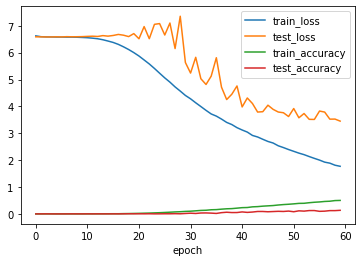

In [35]:
plt.plot(class_history_2.history['loss'])
plt.plot(class_history_2.history['val_loss'])
plt.plot(class_history_2.history['accuracy'])
plt.plot(class_history_2.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss', 'train_accuracy', 'test_accuracy'], loc='upper right')
plt.show()

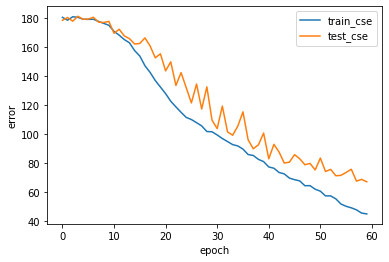

In [34]:
# plt.plot(class_history_2.history['loss'])
# plt.plot(class_history_2.history['val_loss'])
# plt.plot(class_history_2.history['accuracy'])
# plt.plot(class_history_2.history['val_accuracy'])
plt.plot(class_history_2.history['common_sense_class'])
plt.plot(class_history_2.history['val_common_sense_class'])
# plt.title('Classification_720')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train_cse', 'test_cse'], loc='upper right')
plt.show()

## Multi-head models

In [4]:
# basic parameter settings
batch_size = 64
num_classes = 12
epochs = 200

# change the two-integer labels to two categories
y_hours_train, y_minutes_train = np.split(y_train, 2, 1)
y_hours_test, y_minutes_test = np.split(y_test, 2, 1)

# convert hour vectors to binary hour matrices
y_hours_train = keras.utils.to_categorical(y_hours_train, num_classes)
y_hours_test = keras.utils.to_categorical(y_hours_test, num_classes)

In [6]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3, 3), activation="relu", padding="same")

img_input = keras.layers.Input(shape=input_shape)
block1_conv1 = DefaultConv2D(filters=32)(img_input)
block1_pool = keras.layers.MaxPooling2D(pool_size=2)(block1_conv1)
block1_norm = keras.layers.BatchNormalization()(block1_pool)
block1_drop = keras.layers.Dropout(0.2)(block1_norm)

block2_conv1 = DefaultConv2D(filters=64)(block1_drop)
block2_conv2 = DefaultConv2D(filters=64)(block2_conv1)
block2_pool = keras.layers.MaxPooling2D(pool_size=2)(block2_conv2)
block2_norm = keras.layers.BatchNormalization()(block2_pool)
block2_drop = keras.layers.Dropout(0.2)(block2_norm)

block3_conv1 = DefaultConv2D(filters=96)(block2_drop)
block3_pool = keras.layers.MaxPooling2D(pool_size=2)(block3_conv1)
block3_norm = keras.layers.BatchNormalization()(block3_pool)
block3_drop = keras.layers.Dropout(0.2)(block3_norm)

block4_conv1 = DefaultConv2D(filters=128)(block3_drop)
block4_pool = keras.layers.MaxPooling2D(pool_size=2)(block4_conv1)
block4_norm = keras.layers.BatchNormalization()(block4_pool)
block4_drop = keras.layers.Dropout(0.2)(block4_norm)

flatten = keras.layers.Flatten()(block4_drop)
fc1 = keras.layers.Dense(units=256, activation="relu")(flatten)
drop1 = keras.layers.Dropout(0.2)(fc1)
fc2 = keras.layers.Dense(128, activation="relu")(drop1)
drop2 = keras.layers.Dropout(0.2)(fc2)

hour_class = keras.layers.Dense(num_classes, activation="softmax", name="hour_class")(drop2)
minute_reg = keras.layers.Dense(1, activation='linear', name="minute_reg")(drop2)
multi_model = keras.models.Model(inputs=[img_input], outputs=[hour_class, minute_reg])

In [7]:
multi_model.compile(loss={'hour_class': "categorical_crossentropy", 'minute_reg': "mean_absolute_error"},
                    loss_weights={'hour_class': 1.0, 'minute_reg': 0.2},
                    optimizer=keras.optimizers.Adadelta(learning_rate=0.1), 
                    metrics={'hour_class': "accuracy", 'minute_reg': []})
# multi_model.compile(loss=["categorical_crossentropy", custom_mae], optimizer=keras.optimizers.Adadelta(learning_rate=0.1), 
#               metrics=["accuracy", common_sense_class, common_sense_reg]) # optimizer=[keras.optimizers.Adadelta(learning_rate=0.1), "sgd"]

multi_history = multi_model.fit(X_train, (y_hours_train, y_minutes_train), batch_size=batch_size, epochs=epochs, verbose=1, 
                    validation_data=(X_test, (y_hours_test, y_minutes_test)))
score = multi_model.evaluate(X_test, (y_hours_test, y_minutes_test), verbose=0)
print('Test loss:', score[0])
print('Test hour loss:', score[1])
print('Test minute loss:', score[2])
print('Test hour accuracy:', score[3])
# print('Test minute MeanAbsoluteError:', score[4])

Epoch 1/200


2022-11-25 19:10:05.358210: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


225/225 [==============================] - 14s 34ms/step - loss: 6.7397 - hour_class_loss: 3.3074 - minute_reg_loss: 17.1616 - hour_class_accuracy: 0.0876 - val_loss: 8.0511 - val_hour_class_loss: 2.6058 - val_minute_reg_loss: 27.2263 - val_hour_class_accuracy: 0.0836
Epoch 2/200
225/225 [==============================] - 6s 27ms/step - loss: 5.7931 - hour_class_loss: 2.9180 - minute_reg_loss: 14.3759 - hour_class_accuracy: 0.1081 - val_loss: 8.2019 - val_hour_class_loss: 2.6433 - val_minute_reg_loss: 27.7926 - val_hour_class_accuracy: 0.0858
Epoch 3/200
225/225 [==============================] - 6s 27ms/step - loss: 5.2541 - hour_class_loss: 2.6592 - minute_reg_loss: 12.9746 - hour_class_accuracy: 0.1325 - val_loss: 7.6491 - val_hour_class_loss: 2.5678 - val_minute_reg_loss: 25.4067 - val_hour_class_accuracy: 0.1019
Epoch 4/200
225/225 [==============================] - 6s 27ms/step - loss: 4.9463 - hour_class_loss: 2.4806 - minute_reg_loss: 12.3287 - hour_class_accuracy: 0.1648 - val

In [8]:
multi_model.save("Multi_head.h5")

In [9]:
print(multi_history.history.keys())

dict_keys(['loss', 'hour_class_loss', 'minute_reg_loss', 'hour_class_accuracy', 'val_loss', 'val_hour_class_loss', 'val_minute_reg_loss', 'val_hour_class_accuracy'])


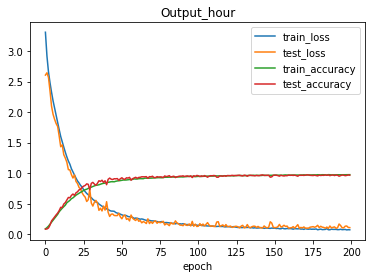

In [13]:
plt.plot(figsize=(8, 5))
plt.plot(multi_history.history['hour_class_loss'])
plt.plot(multi_history.history['val_hour_class_loss'])
plt.plot(multi_history.history['hour_class_accuracy'])
plt.plot(multi_history.history['val_hour_class_accuracy'])
plt.title('Output_hour')
# plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss', 'train_accuracy', 'test_accuracy'], loc='upper right')
plt.show()

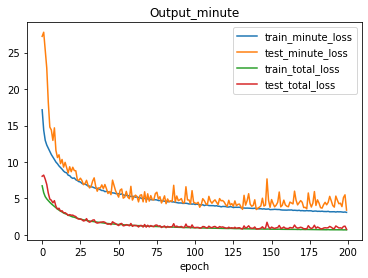

In [17]:
plt.plot(multi_history.history['minute_reg_loss'])
plt.plot(multi_history.history['val_minute_reg_loss'])
plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('Output_minute')
# plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_minute_loss', 'test_minute_loss', 'train_total_loss', 'test_total_loss'], loc='upper right')
plt.show()

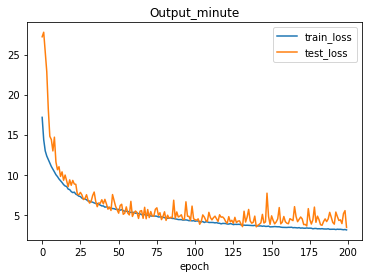

In [19]:
plt.plot(multi_history.history['minute_reg_loss'])
plt.plot(multi_history.history['val_minute_reg_loss'])
# plt.plot(multi_history.history['loss'])
# plt.plot(multi_history.history['val_loss'])
plt.title('Output_minute')
# plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

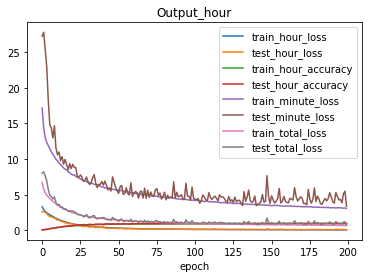

In [20]:
plt.plot(figsize=(8, 5))
plt.plot(multi_history.history['hour_class_loss'])
plt.plot(multi_history.history['val_hour_class_loss'])
plt.plot(multi_history.history['hour_class_accuracy'])
plt.plot(multi_history.history['val_hour_class_accuracy'])
plt.plot(multi_history.history['minute_reg_loss'])
plt.plot(multi_history.history['val_minute_reg_loss'])
plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('Output_hour')
# plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_hour_loss', 'test_hour_loss', 'train_hour_accuracy', 'test_hour_accuracy', 'train_minute_loss', 'test_minute_loss', 'train_total_loss', 'test_total_loss'], loc='upper right')
plt.show()

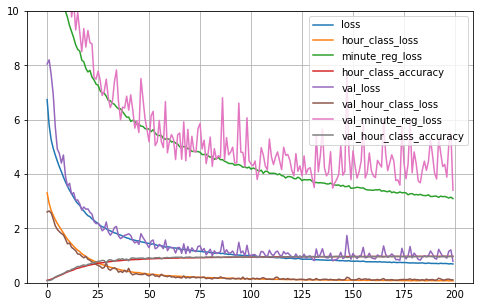

In [12]:
pd.DataFrame(multi_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10)
plt.show()

In [18]:
# the common sense accuracy for Multi model
y_pred = multi_model.predict(X_test)
prediction = np.concatenate([np.argmax(y_pred[0], 1).reshape(3600, 1), y_pred[1]], axis=1)
true = np.concatenate([np.argmax(y_hours_test, 1).reshape(3600, 1), y_minutes_test], axis=1)
y_true = true[:, 0] + true[:, 1] / 60.0
y_prediction = prediction[:, 0] + prediction[:, 1] / 60.0

def common_sense_multi(y_true, y_pred):
    differences = np.abs(y_true - y_pred)
    diff = np.minimum(differences, np.subtract(12.0, differences))
    diff = np.mean(diff, axis=-1)
    return diff

cse = common_sense_multi(y_true, y_prediction)
print(cse)

113/113 [==============================] - 1s 4ms/step
0.08255910437830069
